In [14]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np


## Constants

In [95]:
chess_board_size = (7, 5)
frame_size = (3840, 1080)
square_size = 29.0

## Image Capture

In [16]:
cap = cv2.VideoCapture(1)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_size[0])
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_size[1])

True

In [17]:
def capture(ax_left, ax_right, save=False, plot=True):
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image from camera.")
    else:
        shape = frame.shape
        print(f"Captured image shape: {shape}")
        left = frame[:, :shape[1] // 2]
        right = frame[:, shape[1] // 2:]

        idx = max([int(name.split('.')[0].split('_')[1]) for name in os.listdir('./tuning_images/left/')]) + 1 if os.listdir('./tuning_images/left/') else 0
        if save:
            cv2.imwrite(f'./tuning_images/left/img_{idx}.jpg', left)
            cv2.imwrite(f'./tuning_images/right/img_{idx}.jpg', right)
            print("Images saved successfully.")

        if plot and ax_left is not None and ax_right is not None:
            ax_left.imshow(left)
            ax_right.imshow(right)
            ax_left.axis('off')
            ax_right.axis('off')

Captured image shape: (1080, 3840, 3)


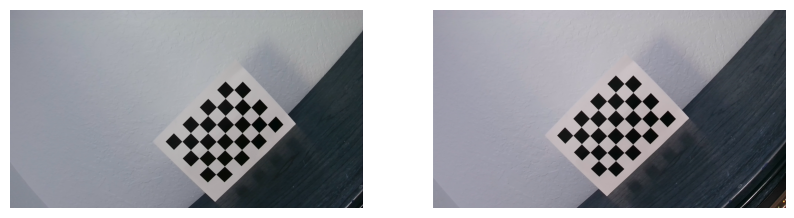

In [91]:
num_images = 1
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
if num_images == 1:
    axes = [axes]
for i in range(num_images):
    ax_left, ax_right = axes[i]
    capture(ax_left, ax_right, save=False, plot=True)


In [92]:
capture(None, None, save=True, plot=False)

Captured image shape: (1080, 3840, 3)
Images saved successfully.


In [13]:
cap.release()

## Calibration

In [187]:
object_points = np.zeros((chess_board_size[0] * chess_board_size[1], 3), np.float32)
object_points[:, :2] = np.mgrid[0:chess_board_size[0], 0:chess_board_size[1]].T.reshape(-1, 2)
object_points *= square_size
object_points.shape

(35, 3)

In [188]:
images = max([int(img.split('.')[0].split('_')[1]) for img in os.listdir('./tuning_images/left/')])
images

8

In [189]:
object_points_list = [object_points.copy() for _ in range(images + 1)]

In [190]:
def get_corners(num_images, camera_side):
    corner_points = []

    for i in range(num_images):
        img_path = f'./tuning_images/{camera_side}/img_{i}.jpg'
        img = cv2.imread(img_path)
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(img_grey, chess_board_size, None)
        if ret:
            print(f"Found corners in image: {i}")
            corner_points.append(corners)
        else:
            print(f"Failed to find corners in image: {i}")

    return corner_points


In [191]:
corner_points_left = get_corners(images + 1, 'left')
corner_points_right = get_corners(images + 1, 'right')

Found corners in image: 0
Found corners in image: 1
Found corners in image: 2
Found corners in image: 3
Found corners in image: 4
Found corners in image: 5
Found corners in image: 6
Found corners in image: 7
Found corners in image: 8
Found corners in image: 0
Found corners in image: 1
Found corners in image: 2
Found corners in image: 3
Found corners in image: 4
Found corners in image: 5
Found corners in image: 6
Found corners in image: 7
Found corners in image: 8


In [192]:
def calibrate(object_points_list, corner_points_left, corner_points_right, frame_size):
    ret_left, K_left, D_left, rvecs_left, tvecs_left = cv2.calibrateCamera(object_points_list, corner_points_left, frame_size, None, None)
    ret_right, K_right, D_right, rvecs_right, tvecs_right = cv2.calibrateCamera(object_points_list, corner_points_right, frame_size, None, None)
    print(f"Left camera calibration: {ret_left}, Right camera calibration: {ret_right}")

    ret, K_left, D_left, K_right, D_right, R, T, E, F = cv2.stereoCalibrate(object_points_list, corner_points_left, corner_points_right, K_left, D_left, K_right, D_right, frame_size, None, None, None, None)
    print(f"Stereo calibration: {ret}")

    R_left, R_right, P_left, P_right, Q, roi1, roi2 = cv2.stereoRectify(K_left, D_left, K_right, D_right, frame_size, R, T)

    mapx_left, mapy_left = cv2.initUndistortRectifyMap(K_left, D_left, R_left, P_left, frame_size, cv2.CV_32FC1)
    mapx_right, mapy_right = cv2.initUndistortRectifyMap(K_right, D_right, R_right, P_right, frame_size, cv2.CV_32FC1)

    return mapx_left, mapy_left, mapx_right, mapy_right, K_left, D_left, K_right, D_right, R, T, Q

In [193]:
mapx_left, mapy_left, mapx_right, mapy_right, K_left, D_left, K_right, D_right, R, T, Q = calibrate(object_points_list, corner_points_left, corner_points_right, (frame_size[0] // 2, frame_size[1]))

Left camera calibration: 0.638141810367177, Right camera calibration: 0.47907383223874433
Stereo calibration: 0.6178563064804743


In [230]:
def measure_distance(stereo_frame, stereo, mapx_left, mapy_left, mapx_right, mapy_right):
    frame_left = cv2.cvtColor(stereo_frame[:, : frame_size[0] // 2], cv2.COLOR_BGR2RGB)
    frame_right = cv2.cvtColor(stereo_frame[:, frame_size[0] // 2:], cv2.COLOR_BGR2RGB)

    grey_frame = cv2.cvtColor(stereo_frame, cv2.COLOR_BGR2GRAY)
    
    grey_frame_left = grey_frame[:, : frame_size[0] // 2]
    grey_frame_right = grey_frame[:, frame_size[0] // 2:]

    remap_left = cv2.remap(grey_frame_left, mapx_left, mapy_left, cv2.INTER_LINEAR)
    remap_right = cv2.remap(grey_frame_right, mapx_right, mapy_right, cv2.INTER_LINEAR)

    disparity = stereo.compute(np.uint8(remap_left), np.uint8(remap_right)).astype(np.float32) / 16.0

    plt.figure(figsize=(16, 9))

    plt.subplot(2, 2, 1)
    plt.imshow(frame_left)
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(frame_right)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(remap_left, cmap='gray')
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(remap_right, cmap='gray')
    plt.axis('off')

    return disparity

In [231]:
stereo = cv2.StereoSGBM.create(
    minDisparity=0,
    numDisparities=128,
    blockSize=9,
    P1=8*3*9**2,
    P2=32*3*9**2,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    disp12MaxDiff=1
)

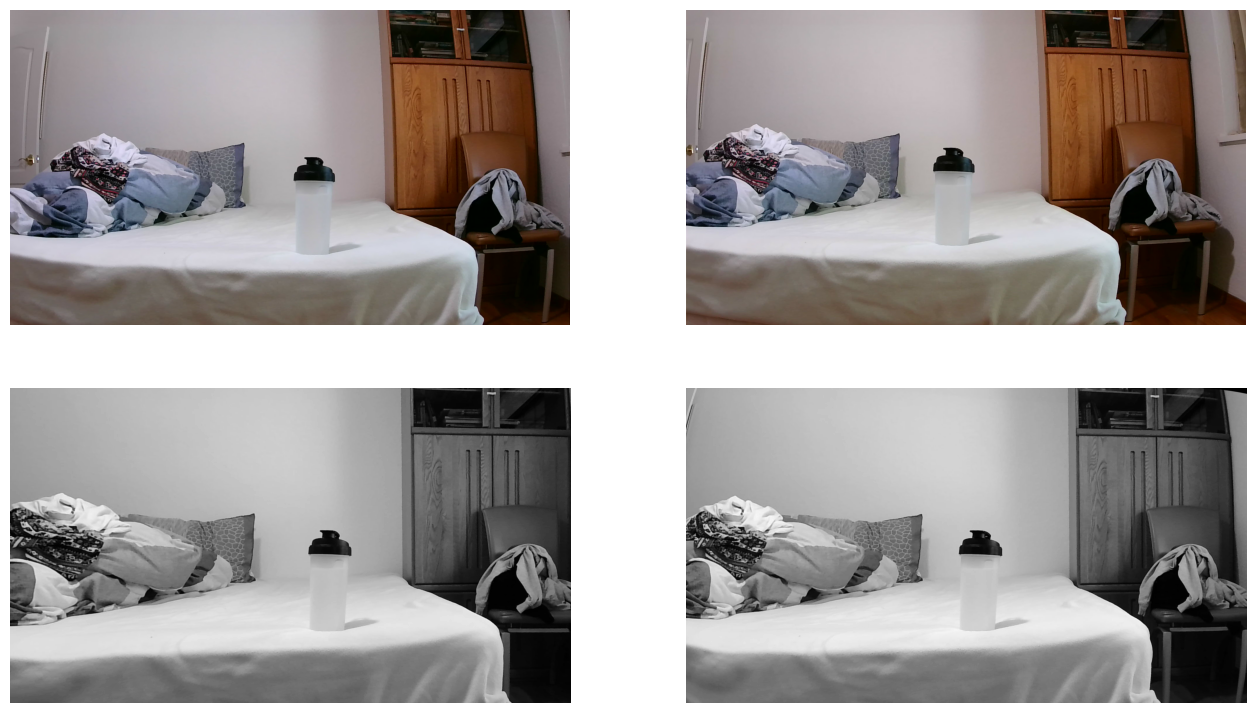

In [232]:
ret, frame = cap.read()
disparity = measure_distance(frame, stereo, mapx_left, mapy_left, mapx_right, mapy_right)

(-0.5, 1919.5, 1079.5, -0.5)

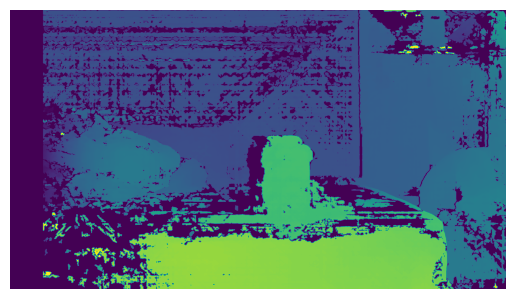

In [233]:
disp_vis = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
disp_vis = np.uint8(disp_vis)
plt.imshow(disp_vis)
plt.axis('off')

Depth stats:
  Min: -89538.40625
  Max: inf
  Mean: inf
  Valid points: 1471870 / 2073600


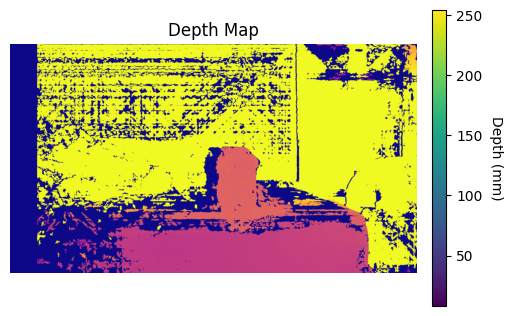

In [238]:
point_cloud = cv2.reprojectImageTo3D(disparity, Q)
depth = point_cloud[:, :, 2]
valid = np.isfinite(depth) & (depth > 0)

print("Depth stats:")
print(f"  Min: {np.nanmin(depth)}")
print(f"  Max: {np.nanmax(depth)}")
print(f"  Mean: {np.nanmean(depth)}")
print(f"  Valid points: {np.sum(valid)} / {depth.size}")

depth_vis = np.clip(depth, 300, 1500)  # Adjust these bounds as needed
depth_vis = cv2.normalize(depth_vis, None, 0, 255, cv2.NORM_MINMAX)
depth_vis = np.uint8(depth_vis)
depth_colored = cv2.applyColorMap(depth_vis, cv2.COLORMAP_PLASMA)

img = plt.imshow(cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB))
plt.title("Depth Map")
plt.axis('off')

# Add colorbar with depth units
cbar = plt.colorbar(img, shrink=0.8, pad=0.03)
cbar.set_label('Depth (mm)', rotation=270, labelpad=15)

